In [10]:
import torch.nn as nn
import numpy as np
import argparse
import torch
import timm
import random
import time
import pickle
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import transforms

In [11]:
class Dataset(object):
    
    def __init__(self, x0, x1, label):
        self.size = label.shape[0] 
        self.x0 = torch.from_numpy(x0)
        self.x1 = torch.from_numpy(x1)
        self.label = torch.from_numpy(label)

    def __getitem__(self, index):
        return (self.x0[index],
                self.x1[index],
                self.label[index])

    def __len__(self):
        return self.size

In [12]:
def create_pairs(data, digit_indices):
    x0_data = []
    x1_data = []
    label = []
    n = min([len(digit_indices[d]) for d in range(2)]) - 1
    for d in range(2): 
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            x0_data.append(data[z1]/255.) 
            x1_data.append(data[z2]/255.) 
            label.append(1)
            inc = random.randrange(1, 4)
            dn = (d + inc) % 2
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            x0_data.append(data[z1]/255.) 
            x1_data.append(data[z2]/255.) 
            label.append(0)

    x0_data = np.array(x0_data, dtype=np.float32) 

    x0_data = x0_data.reshape([-1, 3, 224, 224])
    x1_data = np.array(x1_data, dtype=np.float32) 
    x1_data = x1_data.reshape([-1, 3, 224, 224])
    label = np.array(label, dtype=np.int32)

    return x0_data, x1_data, label

def create_iterator(data, label, batchsize, shuffle=False):

    digit_indices = [np.where(label == i)[0] for i in range(max(label)+1)]
    x0, x1, label = create_pairs(data, digit_indices)
    ret = Dataset(x0, x1, label)
    return ret

In [13]:
def contrastive_loss_function(x0, x1, y, margin=1.0):
    diff = x0 - x1
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)
    mdist = margin - dist
    dist = torch.clamp(mdist, min=0.0)
    loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
    loss = torch.sum(loss) / 2.0 / x0.size()[0]
    return loss

In [14]:
batchsize=8
import copy
import timm

class SiameseNetwork_densenet201(nn.Module):
    
    def __init__(self):
        super(SiameseNetwork_densenet201, self).__init__()
        self.cnn0 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
        

    def forward_once(self, x):
        output = self.cnn0(x)
        return output

    def forward(self, input0, input1):
        output0 = self.forward_once(input0)
        output1 = self.forward_once(input1)
        return output0, output1

In [15]:
import os
import shutil
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.applications import xception
from keras.applications.vgg16 import preprocess_input
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

def extract_features(path):
    directory_lists=os.listdir(path)
    X=[]
    Y=[]
    count=0
    for d in directory_lists:
        nest=os.listdir(path+"/"+d)
        for f in nest:
            img = image.load_img(path+"/"+d+"/"+f, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = preprocess_input(img_data)
            img_data = np.expand_dims(img_data, axis=0)
            X.append(img_data)
            Y.append(count)
        count+=1
    X=np.array(X)
    y=np.array(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)         
    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = extract_features("/content/drive/MyDrive/few_shot/train/")
print (X_train.shape, y_train.shape)

(72, 1, 224, 224, 3) (72,)


In [16]:
train_iter = create_iterator(X_train,y_train,batchsize)
test_iter = create_iterator(X_test,y_test,batchsize)

model = SiameseNetwork_densenet201()

learning_rate = 0.0001 
momentum = 0.9 


criterion =  contrastive_loss_function

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, verbose=True)

train_loader = torch.utils.data.DataLoader(train_iter,batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_iter,batch_size=2, shuffle=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [17]:
train_loss = []
epochs = 10
for epoch in range(epochs):
    total_loss = 0.0
    for batch_idx, (x0, x1, labels) in enumerate(train_loader):
        labels = labels.float()
        x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
        output1, output2 = model.forward(x0, x1)
        loss = criterion(output1, output2, labels)
        train_loss.append(loss.item())
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step(epoch)
    print('Epoch: {} \tLoss: {:.6f}'.format(epoch, total_loss*1.0/batchsize))
    if epoch%50==0:
        torch.save(model, './SiameseModified-epoch-%s.pth' % epoch)

Epoch: 0 	Loss: 503.785916
Epoch: 1 	Loss: 10.392206
Epoch: 2 	Loss: 1.169564
Epoch: 3 	Loss: 0.661335
Epoch: 4 	Loss: 0.541113
Epoch: 5 	Loss: 0.441757
Epoch: 6 	Loss: 0.367646
Epoch: 7 	Loss: 0.368063
Epoch: 8 	Loss: 0.358841
Epoch: 9 	Loss: 0.352594


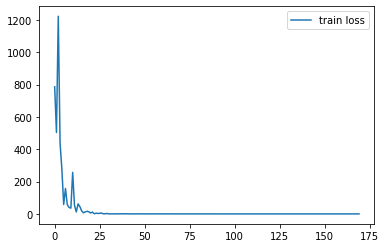

In [18]:
def plot_loss(train_loss,name="train_loss.png"):
    plt.plot(train_loss, label="train loss")
    plt.legend()
plot_loss(train_loss)

In [19]:
def plot_vis(numpy_all, numpy_labels,name="./embeddings_plot.png"):
        c = ['#ff0000', '#ffff00']
        for i in range(0,2):
            f = numpy_all[np.where(numpy_labels == i)]
            plt.plot(f[:, 0], f[:, 1], '.', c=c[i])
        plt.legend(['0', '1'])
        plt.savefig(name)

0.3014384519695795


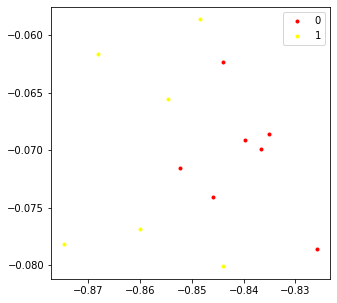

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
X_test = X_test/255.
y_test = np.array(y_test, dtype=np.int32)

def test_model(model):
        model.eval()
        all_ = []
        all_labels = []
        with torch.no_grad():
            for i in range(0, 13):
                x = Variable(torch.tensor(X_test[i].reshape([-1, 3, 224, 224])))
                y_t = np.array(y_test[i], dtype=np.int32)
                y = Variable(torch.tensor(y_t))
                output = model.forward_once(x)
                all_.extend(output.data.cpu().numpy().tolist())
                all_labels.append(y.data.cpu().numpy().tolist())

        numpy_all = np.array(all_)
        numpy_labels = np.array(all_labels)
        return numpy_all, numpy_labels

def testing_plots(model):
        dict_pickle={}
        numpy_all, numpy_labels = test_model(model)
        dict_pickle["numpy_all"]=numpy_all
        dict_pickle["numpy_labels"]=numpy_labels
        clusterer = KMeans(n_clusters=2)
        preds = clusterer.fit_predict(numpy_all)
        centers = clusterer.cluster_centers_
        score = silhouette_score(numpy_all, preds)
        print (score)
        plot_vis(numpy_all, numpy_labels)

from sklearn.metrics import silhouette_samples, silhouette_score
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
testing_plots(model)